In [1]:
# Load the MNIST digit recognition dataset into R
# http://yann.lecun.com/exdb/mnist/
# assume you have all 4 files and gunzip'd them
# creates train$n, train$x, train$y  and test$n, test$x, test$y
# e.g. train$x is a 60000 x 784 matrix, each row is one digit (28x28)
# call:  show_digit(train$x[5,])   to see a digit.
# brendan o'connor - gist.github.com/39760 - anyall.org
load_mnist <- function() {
  load_image_file <- function(filename) {
    ret = list()
    f = file(filename,'rb')
    readBin(f,'integer',n=1,size=4,endian='big')
    ret$n = readBin(f,'integer',n=1,size=4,endian='big')
    nrow = readBin(f,'integer',n=1,size=4,endian='big')
    ncol = readBin(f,'integer',n=1,size=4,endian='big')
    x = readBin(f,'integer',n=ret$n*nrow*ncol,size=1,signed=F)
    ret$x = matrix(x, ncol=nrow*ncol, byrow=T)
    close(f)
    ret
  }
  load_label_file <- function(filename) {
    f = file(filename,'rb')
    readBin(f,'integer',n=1,size=4,endian='big')
    n = readBin(f,'integer',n=1,size=4,endian='big')
    y = readBin(f,'integer',n=n,size=1,signed=F)
    close(f)
    y
  }
  train <<- load_image_file('../input/ministdata/train-images-idx3-ubyte')
  test <<- load_image_file('../input/ministdata/t10k-images-idx3-ubyte')
  
  train$y <<- load_label_file('../input/ministdata/train-labels-idx1-ubyte')
  test$y <<- load_label_file('../input/ministdata/t10k-labels-idx1-ubyte')  
}

show_digit <- function(arr784, col=gray(12:1/12), ...) {
  image(matrix(arr784, nrow=28)[,28:1], col=col, ...)
}

# load data
load_mnist()

# DATA EXPLORATION AND PREPARATION

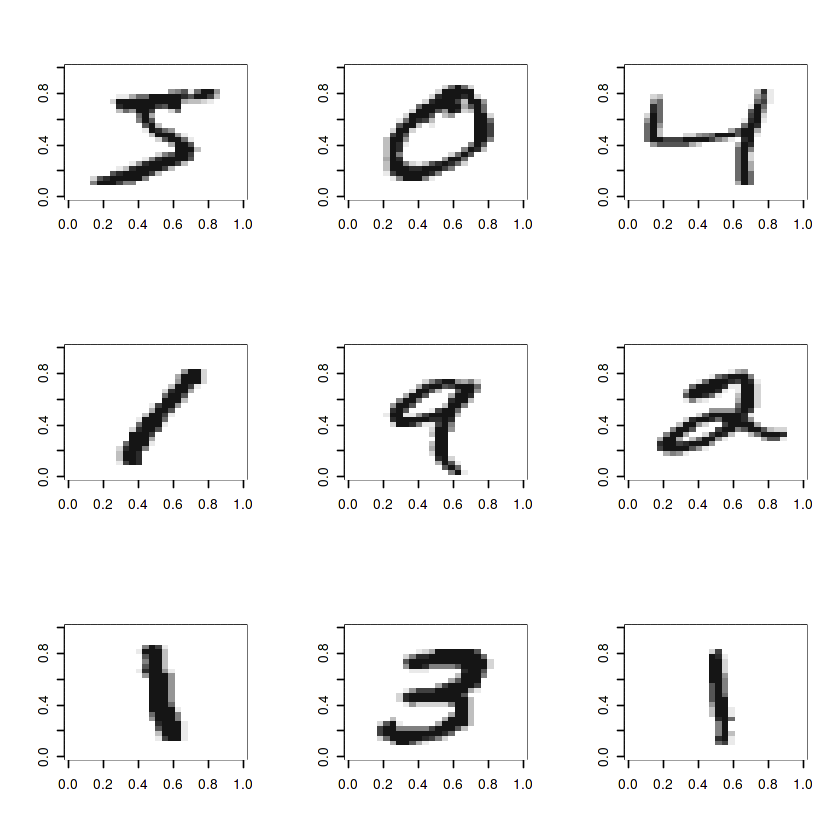

In [2]:
# plot to show the first nine rows in the trian set
par(mfrow = c(3,3))
for (i in 1:9){show_digit(train$x[i,])}

In [3]:
# scalining training set and testing set
train_x <- train$x/255
test_x <- test$x/255
test_y <- test$y
train_y <- train$y

In [4]:
# Checking for missing values 
sum(is.na(train_x)) # indicates thata there is no missing value in the data
sum(is.na(test_x)) # indicates that there is no missing values in the data
sum(is.na(train_y))# indicates that there is no missing values in the data
sum(is.na(test_y))# indicates that there is no missing values in the data

[1] 0

[1] 0

[1] 0

[1] 0

In [5]:
# Check for class imbalance
table(train_y)
table(test_y)

train_y
   0    1    2    3    4    5    6    7    8    9 
5923 6742 5958 6131 5842 5421 5918 6265 5851 5949 

test_y
   0    1    2    3    4    5    6    7    8    9 
 980 1135 1032 1010  982  892  958 1028  974 1009 

In [6]:
# Install Libraries
library(caret)
library(class)
library(ggplot2)
library(caTools)

Loading required package: lattice



Loading required package: ggplot2




Attaching package: ‘caret’




The following object is masked from ‘package:httr’:

    progress




# KNN  MODEL BEFORE PCA

In [ ]:
# KNN without PCA model 1 (k=240)
knn.model <- knn(train = train_x, test = test_x, cl = train_y, k = 240)
knn.model

In [ ]:
# Confusion matrix for KNN without PCA model 1
confusionMatrix(data = as.factor(test_y), reference = knn.model )

In [ ]:
# KNN without PCA model 2 (k=235)
knn.model <- knn(train = train_x, test = test_x, cl = train_y, k = 235)
knn.model

In [ ]:
# Confusion matrix for KNN without PCA model 2
confusionMatrix(data = as.factor(test_y), reference = knn.model )

# XGBOOST MODEL BEFORE PCA

In [ ]:
# XGB before PCA 
xgb <- xgboost(data = data.matrix(train_x), 
 label = train_y,
 eta = 0.1,
 max_depth = 15, 
 nround=95, 
 subsample = 0.5,
 colsample_bytree = 0.5,
 seed = 1,
 eval_metric = "merror",
 objective = "multi:softmax",
 num_class = 12,
 nthread = 3
)

# Predict using the xgb model 
y_pred <- predict(xgb, data.matrix(test_x))

#Get the confusion matrix to see accuracy value and other parameter values
confusionMatrix(as.factor(y_pred), as.factor(test_y))

# Accuracy score  
mean(y_pred == test_y)

#  PRINCIPAL COMPONENT ANALYSIS (PCA)

In [ ]:
# PCA for training and testing set 
mypca_train<- prcomp(train_x,center=TRUE, scale = FALSE) # PCA for training set

mypca_test<- prcomp(test_x,center=TRUE, scale = FALSE) # PCA for testing set

In [ ]:
# ggplot of the first and second principal component

mnist <- as.data.frame(cbind(mypca_train$x[,1:2],train_y))
mnist$train_y<-as.factor(mnist$train_y)
head(mnist)

ggplot(mnist, aes(PC1, PC2,col=train_y, fill=train_y))+geom_point(shape = 21, col='black')+xlab('PC1 10% of variance explianed')+ylab('PC2 7% of variance explianed')

In [ ]:
# Summary of PCA on training set
summary(mypca_train)

In [ ]:
#calculate total variance explained by each principal component
var_explained = mypca_train$sdev^2 / sum(mypca_train$sdev^2)
#create scree plot for the first 200 PCA
qplot(c(1:200), var_explained[1:200]) + 
  geom_line() + 
  xlab("Principal Component") + 
  ylab("Variance Explained") +
  ggtitle("Scree Plot") +scale_x_continuous(breaks=seq(0,200,20))+scale_y_continuous(breaks=seq(0,0.2,0.01))

In [ ]:
#Cumulative proportion of variance explianed by the first 200 PCA 
qplot(c(1:200), cumsum(var_explained[1:200])) + 
  geom_line() + 
  xlab("Principal Component") + 
  ylab("Cumulative Proportion of Variance Explained") +
  ggtitle("Scree Plot") + scale_x_continuous(breaks=seq(0,200,20))+scale_y_continuous(breaks=seq(0,1,0.1))

In [ ]:
# reconstruction of the train data with 12 principal component
reconstruction_12PC = t(t(mypca_train$x[,1:12] %*% t(mypca_train$rotation[,1:12])) + mypca_train$center)
# reconstruction of the train data with 45 principal component
reconstruction_45PC = t(t(mypca_train$x[,1:45] %*%t(mypca_train$rotation[,1:45])) +mypca_train$center)

In [ ]:
# Ploting the first four rows in the reconstruted data using 12 PCA
par(mfrow = c(2,2))
for (i in 1:4){show_digit(reconstruction_12PC[i,], main ="12 Component")}

In [ ]:
# Plotting the four rows in the reconstructed data using  45 PCA
par(mfrow = c(2,2))
for (i in 1:4){show_digit(reconstruction_45PC[i,], main ="45 Component")}

In [ ]:
# Plotting Principal component one and two
plot(mypca_train$x, col=train_y, main = 'PC1 v PC2 by Label')

In [ ]:
# Assigning new variable to principal component for train and test set
train_new <- predict(mypca_train,train_x)
test_new <- predict(mypca_train,test_x)

# KNN  MODEL AFTER

In [ ]:
# KNN algorithm with 12 PCA 
KNN.opt = c()
KNN.tp = c()
for (i in 3:250){
    knn.model <- knn(train = train_new[,1:12], test = test_new[,1:12], cl = train_y, k = i)
    KNN.opt[i]<- mean(knn.model == test_y)*100
    KNN.tp[i]<-mean(knn.model!=test_y)*100
    k=i
    cat(k,"=",KNN.opt[i], '\n')
}

# Plot the accuracy score for the various values of k using 12 PCA
qplot(c(3:250),KNN.opt[3:250])+ geom_line()+geom_line() + xlab("K-value") + ylab("Accuracy")+scale_y_continuous(breaks=seq(90,95,0.2))+scale_x_continuous(breaks=seq(0,250,25))

# Plot the error rate score for the various values of k using 12 PCA
qplot(c(3:250),KNN.tp[3:250])+ geom_line()+geom_line() + xlab("K-value") + ylab("Error rate")+scale_y_continuous(breaks=seq(5,9,0.5))+scale_x_continuous(breaks=seq(0,250,25))

In [ ]:
#Get the confusion matrix to see accuracy value and other parameter values                                                                                 
confusionMatrix(as.factor(knn.model), as.factor(test_y))
# Accuracy score                                                                                 
mean(knn.model == test_y)

In [ ]:
# KNN algorithm with 45 PCA 
KNN.opt = 1
KNN.tp = 1
for (i in 3:250){
    knn.model <- knn(train = train_new[,1:45], test = test_new[,1:45], cl = train_y, k = i)
    KNN.opt[i]<- mean(knn.model == test_y)*100
    KNN.tp[i]<-mean(knn.model!=test_y)*100
    k=i
    cat(k,"=",KNN.opt[i], '\n')
}
# Plot the accuracy score for the various values of k using 45 PCA
qplot(c(3:250),KNN.opt[3:250])+ geom_point() + xlab("K-value") + ylab("Accuracy")+scale_y_continuous(breaks=seq(90,100,0.2))+scale_x_continuous(breaks=seq(0,250,25))

# Plot the error rate score for the various values of k using 45 PCA
qplot(c(3:250),KNN.tp[3:250])+ geom_line()+geom_line() + xlab("K-value") + ylab("Error rate")+scale_y_continuous(breaks=seq(0,10,0.5))+scale_x_continuous(breaks=seq(0,250,25))

In [ ]:
#Get the confusion matrix to see accuracy value and other parameter values                                                                                 
confusionMatrix(as.factor(knn.model), as.factor(test_y))
# Accuracy score  
mean(knn.model == test_y)

# XGBOOST MODEL AFTER PCA

In [ ]:
# XGB AFTER PCA USING 12 COMPONENT
xgb <- xgboost(data = data.matrix(train_new[,1:12]), 
 label = train_y,
 eta = 0.1,
 max_depth = 15, 
 nround=95, 
 subsample = 0.5,
 colsample_bytree = 0.5,
 seed = 1,
 eval_metric = "merror",
 objective = "multi:softmax",
 num_class = 12,
 nthread = 3
)
y_pred_PCA <- predict(xgb, data.matrix(test_new[,1:12]))
#Accuracy score
mean(y_pred_PCA == test_y)*100

#Confusion marix
confusionMatrix(as.factor(y_pred_PCA), as.factor(test_y))

In [ ]:
# XGB AFTER PCA USING 45 COMPONENT
xgb <- xgboost(data = data.matrix(train_new[,1:45]), 
 label = train_y,
 eta = 0.1,
 max_depth = 15, 
 nround=95, 
 subsample = 0.5,
 colsample_bytree = 0.5,
 seed = 1,
 eval_metric = "merror",
 objective = "multi:softmax",
 num_class = 12,
 nthread = 3
)
y_pred_PCA <- predict(xgb, data.matrix(test_new[,1:45]))
#Accuracy score 
mean(y_pred_PCA == test_y)*100
#Confusion marix
confusionMatrix(as.factor(y_pred_PCA), as.factor(test_y))